# Using LDA to conduct topic modelling on Coursera data

<strong>The descriptions and summaries will be aggregated into a bag-of-words and the LDA model from Gensim will be used to generate n topics for each program (decided using grid search).</strong>

## (1) Import libraries and coursera data into notebook

In [2]:
import pandas as pd
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel

import numpy as np


In [3]:
# Step 1: Extract and preprocess documents
documents = []
for i in range(475):  # Your 475 files
    file_path = f"../corpus/program{i}.txt"
    with open(file_path, 'r') as file:
        content = file.read()
        # Extract content between DOC tags
        docs = re.findall(r'<DOC>(.*?)</DOC>', content, re.DOTALL)
        documents.extend(docs)

## (2) Cleaning and preprocessing text to create dictionary for LDA model

In [4]:
nlp = spacy.load("en_core_web_sm")

In [5]:
coursera_stopwords = { # extension of the stop words - for now this is all I have, but feel free to add on more 
    "\n", "course", "program", "learn", "learning", "outcome", "outcomes",
    "description", "skill", "skills", "module", "modules", "specialization",
    "specialisation", "certificate", "certificates", "certificate,", "certificates,",
    "professional", "career", "opportunity", "opportunities", "project", "projects", "work", "experience", "experiences"
}
STOP_WORDS = STOP_WORDS.union(coursera_stopwords)

def preprocess_text(text: str):
    '''
    preprocessing 
    1. lowercase conversion 
    2. removing nonalphanum
    3. stopwords, puncutation, short token and frequent short token removal
    '''
    doc = nlp(text)
    tokens = []
    for token in doc:
        if (token.lemma_ not in STOP_WORDS):
            tokens.append(token.lemma_)
    return tokens

In [6]:
# creating a dictionary for the LDA model
docs = [preprocess_text(doc) for doc in documents]
dictionary_prog = corpora.Dictionary(docs)
dictionary_prog.filter_extremes(no_below=5, no_above=0.5)

In [7]:
# creating BOW corpus
bow_corpus_prog = [dictionary_prog.doc2bow(doc) for doc in docs]
print(f"Number of unique tokens in dictionary: {len(dictionary_prog)}")

print("Example BOW for the first document:", bow_corpus_prog[0][:5])


Number of unique tokens in dictionary: 6681
Example BOW for the first document: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]


## (3) Calculating coherence score + Best number of topics through grid-search 

In [10]:
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    """
    Computes c_v coherence for various values of num_topics.
    
    Returns:
        model_list: List of trained LdaModel
        coherence_values: Coherence values corresponding to the models
    """
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=10,       # tweak for more stable training
            alpha='auto',    # auto tuning of alpha by gensim
            per_word_topics=True
        )
        model_list.append(model)
        
        # calcuate coherence score
        coherencemodel = CoherenceModel(
            model=model, 
            texts=texts, 
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_values.append(coherencemodel.get_coherence())
    
    return model_list, coherence_values

start, limit, step = 14, 31, 2
model_list, coherence_values = compute_coherence_values(
    dictionary_prog, 
    bow_corpus_prog, 
    docs, 
    start, 
    limit, 
    step
)

# identifying best coherence
best_index = np.argmax(coherence_values)
optimal_num_topics = range(start, limit, step)[best_index]
best_model = model_list[best_index]
best_coherence = coherence_values[best_index]
print("Coherence Values:", coherence_values)
print(f"Best number of topics: {optimal_num_topics} with Coherence = {best_coherence:.4f}")

Coherence Values: [0.44462607562215845, 0.44687495743347105, 0.4487133025809562, 0.44864850502260367, 0.4529236711200065, 0.4516426442616282, 0.426190280730014, 0.44350597830109145, 0.4365015994738745]
Best number of topics: 22 with Coherence = 0.4529


In [8]:
model = LdaModel(
            corpus=bow_corpus_prog,
            id2word=dictionary_prog,
            num_topics=22,
            random_state=42,
            passes=10,       # tweak for more stable training
            alpha='auto',    # auto tuning of alpha by gensim
            per_word_topics=True
        )

In [14]:
new_top_words = []
for i in range(22):
    terms = model.get_topic_terms(i, topn=10)
    term_words = [dictionary_prog[term_id] for term_id, _ in terms]
    new_top_words.append(term_words)

In [16]:
coherencemodel = CoherenceModel(
    topics=new_top_words, 
    texts=docs, 
    dictionary=dictionary_prog,
    coherence='c_v'
)
coherencemodel.get_coherence()

0.5259675651014653

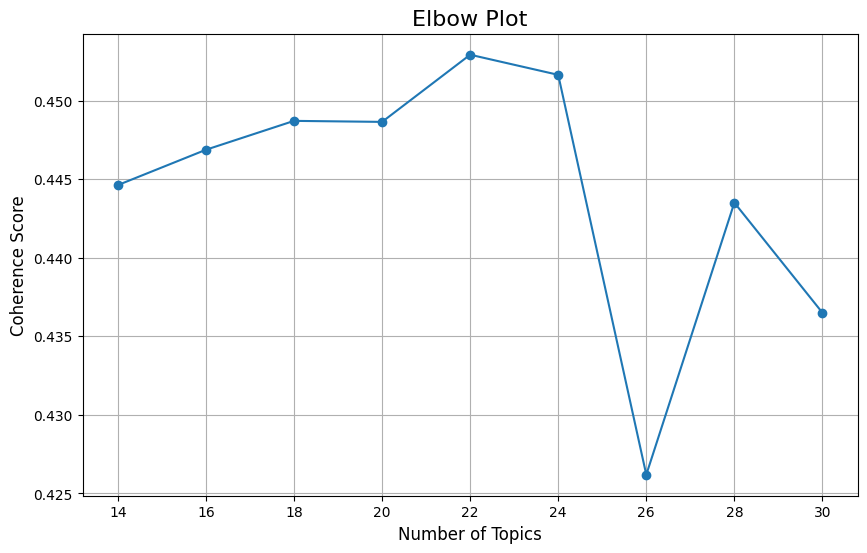

In [13]:
import matplotlib.pyplot as plt

topic_numbers = range(start, limit, step)

plt.figure(figsize=(10, 6))
plt.plot(topic_numbers, coherence_values, marker='o')
plt.title('Elbow Plot', fontsize=16)
plt.xlabel('Number of Topics', fontsize=12)
plt.ylabel('Coherence Score', fontsize=12)
plt.xticks(topic_numbers)
plt.grid(True)
plt.show()

## (4) Viewing top words for each topic

In [19]:
for idx in range(22):
    terms = model.get_topic_terms(idx, topn=8)
    term_words = [dictionary_prog[term_id] for term_id, _ in terms]
    print(f"\nTopic {idx} top words: {term_words}")



Topic 0 top words: ['use', 'code', 'image', 'file', 'python', 'programming', 'web', 'introduction']

Topic 1 top words: ['management', 'process', 'product', 'develop', 'job', 'learner', 'knowledge', 'apply']

Topic 2 top words: ['analysis', 'de', 'statistic', 'variable', 'distribution', 'use', 'statistical', 'method']

Topic 3 top words: ['excel', 'create', 'lecture', 'use', 'chart', 'introduction', 'list', 'basic']

Topic 4 top words: ['design', 'game', 'problem', 'user', 'algorithm', 'solve', 'ux', 'system']

Topic 5 top words: ['function', 'database', 'use', 'sql', 'table', 'datum', 'create', 'query']

Topic 6 top words: ['matrix', 'inventory', 'tech', 'story', 'method', 'planning', 'requirement', 'use']

Topic 7 top words: ['business', 'supply', 'chain', 'analytic', 'analysis', 'buyer', 'analyst', 'introduction']

Topic 8 top words: ['class', 'code', 'ethic', 'java', 'method', 'error', 'negotiation', 'ui']

Topic 9 top words: ['model', 'machine', 'ai', 'use', 'modeling', 'introduc

In [20]:
import pyLDAvis.gensim_models

# Prepare the visualization
vis = pyLDAvis.gensim_models.prepare(model, bow_corpus_prog, dictionary_prog)

# Display the visualization (in a Jupyter notebook, for example)
pyLDAvis.display(vis)


In [21]:
pyLDAvis.save_html(vis, 'lda_visualization.html')

In [1]:
import seaborn as sns
sns

<module 'seaborn' from 'c:\\Python312\\Lib\\site-packages\\seaborn\\__init__.py'>